In [155]:
# Importing data from the r/politics
from psaw import PushshiftAPI
import datetime
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt

# 1. Motivation

### The Reddit dataset

For this project, we chose to work with data from the [r/politics](https://www.reddit.com/r/politics/) subreddit, an online forum with 8 million members "for current and explicitly political U.S. news." according to the rules stated on the site. 

Visitors at r/politics will quickly notice that the majority of the submissions are by users posting links to news articles published on news media sites like CNN or The Huffington Post. The headlines of these linked articles are then shown on r/politics as the titles of the submissions. Other users can then comment on the linked article, which is what ultimately constitutes the actual user-generated content on the site. 

We focused our data extraction to only include submissions from r/politics that fulfilled the following criteria: 
* __They contained "Trump" or "Biden" in the title.__ While submissions containing other words and names than "Trump" and "Biden" (e.g. "Republican" and "Democrat") might be used to provide equally good indications of the political convictions of redditors, this textual query allowed us to limit the scope of the project while still extracting data essential to the aim of this project. 
* __They had received more than five comments.__ This requirement was to prevent us from downloading submissions with no or only a very small comments section, as we'll be using the comments to conduct the later sentiment analysis and produce a partitioning of the redditors. 
* __They had been published between 10-1-2020 and 11-3-2020.__ This period covered approximately a month before the most recent U.S. presidential election that took place on 11-3-2020. Ideally, we would have covered several months leading up to the election day, in order to detect longer term trends in the data. However, that would prove to be computationally infeasible, given the amount of data this would yield. 

__Submission variables__

The downloaded submissions would be structured in a Pandas dataframe containing the following variables for each submission in its respective columns: 
1. __time stamp index:__ Simply stating when the submissions was made.
2. __title:__ Being the title of the submission. Usually the header of the linked article. 
3. __id:__ A unique identifier for a particular submission. 
4. __author:__ The profile name of the author of the submissions.
5. __num_comments:__ The number of comments received on the particular submission.
6. __url:__ The link stated in the text of the submission.

Our query to extract comments from the r/politics subreddit was also focused to only include comments fulfilling the following criteria: 
* __They were related to one of the downloaded submissions.__ 
* __They were posted no later than 11-10-2020.__ By including comments posted up to one week after the election day, we would ensure that we would also have some comments for any submissions made on the election day, without including comments that were made way after the objective period, which would not be representative of the sentiment during the objective period. 

__Comments variables__

As stated, we would download the associated comments section for all the downloaded submissions. Similarly to the submissions, the comments would be structured in a Pandas dataframe containing the following variables for each comment in its respective columns:
1. __time stamp index:__ Simply stating when the submissions was made.
2. __id:__ A unique identifier for a particular submission. 
3. __link_id:__ A unique identifier for the original submission to which the comment relates, somewhere in the comments section.
4. __author:__ The profile name of the author of the submissions.
5. __parent_id:__ A unique identifier for the post to which the comment was made. This may either be a submission or a comment, which is indicated with with the parent_id starting with either "t3_" or "t1_".
6. __body:__ The textual content of the comment. 


__Reasons for choosing this particular data set__ <br>
1. Easy to collect using the Pushshift API.
2. Interesting topic that would fit the requirements of the project.
3. Similar format as the data we've previously worked with.

### The polling dataset
NEEDS EXPLANATION


### Goal for end user's experience
Our goal is for the end user's of our website to have a blast digesting our the findinds of our analyses presented in a beautiful and thought-provoking way. 

Below, we show how we got the data

In [4]:
# Note this is just a POC with a limit=100. 
api = PushshiftAPI()

my_subreddit = "politics"
query = "Trump | Biden "

date1 = int(datetime.datetime(2020,10,1).timestamp())
date2 = int(datetime.datetime(2020,11,3).timestamp())

gen = api.search_submissions(num_comments= '>5',
                             subreddit=my_subreddit, 
                             after=date1, 
                             before=date2, 
                             q=query
                             ,limit=100
                            )
results = list(gen)

C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


In [49]:
column_names = ['title', 'id', 'author', 'num_comments', 'url']

subs_df = pd.DataFrame(
    {
        column_names[0] : [submission.d_[column_names[0]] for submission in results],
        column_names[1] : [submission.d_[column_names[1]] for submission in results],
        column_names[2] : [submission.d_[column_names[2]] for submission in results],
        column_names[3] : [submission.d_[column_names[3]] for submission in results],
        column_names[4] : [submission.d_[column_names[4]] for submission in results]
    },
    index = [submission.d_['created_utc'] for submission in results])
subs_df.index = pd.to_datetime(subs_df.index, unit='s')

To ensure that each submissions is unabigously related to either one of the candidates, we simply remove all submissions containing both "Trump" and "Biden". 

In [51]:
# List to contain indices of subs in df with a title containing both "Trump" and "Biden"
TB = []
for i in range(len(df['title'])):
    if (re.search('Trump', subs_df['title'][i])) and (re.search('Biden', subs_df['title'][i])):
        TB.append(i)
    else:
        continue
        
subs_df = subs_df.drop(subs_df.index[TB])

In [329]:
sub_data = subs_df

Now we're ready to download the associated comments sections for each of the remaining submissions. 

In [179]:
date3 = int(datetime.datetime(2020,11,10).timestamp())

comments = []
for link_id in tqdm(subs_df['id']):
    gen = api.search_comments(subreddit=my_subreddit,
                              link_id=link_id,
                              before=date3)
    comment_sec = list(gen)
    comments += comment_sec

  0%|          | 0/82 [00:00<?, ?it/s]C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
 12%|█▏        | 10/82 [00:16<01:44,  1.46s/it]C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
100%|██████████| 82/82 [04:32<00:00,  3.32s/it]


In [323]:
column_names = ['id', 'link_id', 'author', 'parent_id', 'body']

coms_df = pd.DataFrame(
    {
        column_names[0] : [comment.d_[column_names[0]] for comment in comments],
        column_names[1] : [comment.d_[column_names[1]] for comment in comments],
        column_names[2] : [comment.d_[column_names[2]] for comment in comments],
        column_names[3] : [comment.d_[column_names[3]] for comment in comments],
        column_names[4] : [comment.d_[column_names[4]] for comment in comments]
    },
    columns= column_names, index = [comment.d_['created_utc'] for comment in comments])

coms_df.index = pd.to_datetime(coms_df.index, unit='s')

# 2 Cleaning, preprocessing and stats

In this section we will dicuss our cleaning and preprocessing of the collected data.
Our main data is the collected comments dataframe. 

### Cleaning and preprocessing the comments
The main reason for having to clean the comments data is to prepare it for the later sentiment analysis. For this analysis, we will be using the Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53)) module from the nltk.sentiment library, which has been specifically created to work with text produced on social media. One of the great features of this module is that it is quite robust in terms of the needed data cleaning and processing to function properly. Typical processing steps like tokenization and stemming as well as removing stop words are consequently not required to have the VADER module work well and provide an indication of the sentiment of a body of text. 

In [320]:
# Downloading the comments data set
url = 'https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_comments_very_smol_fully_processed.csv'
coms_df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [324]:
# Only look at the first 1000 comments as a POC
com_data = coms_df

__Removing deleted comments__<br>
Some of the comments have been removed after being posted, so we'll do some cleaning first by filtering out the comments where author = "[deleted]", which will do the job. Similarly, we found that a large part of the comments were made by moderator robots reminding real redditors to behave in accordance with the subreddit rules. Comments made by these bots are also removed. 

In [325]:
com_data = com_data.drop(com_data[com_data['author'] == '[deleted]'].index)
com_data = com_data.drop(com_data[com_data['author'] == 'AutoModerator'].index)
com_data = com_data.drop(com_data[com_data['author'] == 'PoliticsModeratorBot'].index)

__Removing comments by authors with less than 5 comments__<br>
We also remove all comments by authors who have posted less than 5 comments in total. The reason for this being that we would like to have a more solid foundation on which to infer the political convictions of the redditors, which would not be achieved if we had only very few comments made by them.

In [326]:
com_data = com_data.groupby('author').filter(lambda x : len(x)>=5)

__Tokenization__ <br>
As we will also be looking into producing other textual analyses than the VADER sentiment scores, like wordclouds, we will also need to do some tokenization ourselves. 
For the body of each comment, we will do the following steps: 
   * Exclude punctuation.
   * Exclude URLs
   * Exclude English stop words
   * Exclude numbers.
   * Set everything to lower case. 
   
The results of this preprocessing will be a new column in the comments dataframe containing the cleaned tokens of the text body. 

In [327]:
# Define stop words to also include punctuation
stop = set(stopwords.words('english') + list(string.punctuation))
def clean_tokens(text):
    tokens = word_tokenize(text)
    clean_tokens = [re.sub(r'http', '', i).lower() for i in tokens if (i not in stop and str(i).isalpha())]
    return clean_tokens

com_data["tokens"] = com_data.progress_apply(lambda x: clean_tokens(x["body"]), axis=1)

100%|██████████| 1508/1508 [00:00<00:00, 1793.81it/s]


__Finding parent authors for the comments__<br>
To later build our network of redditors, we will populate the comments dataframe with the names of the parents.

In [335]:
comment_authors = dict(zip(com_data.id, com_data.author))
parent = dict(zip(com_data.id, com_data.parent_id))
submission_authors = dict(zip(sub_data.id, sub_data.author))

In [337]:
def find_parent_author(comment_id):
    parent_id = parent[comment_id]    
    
    if parent_id[:3] == 't1_':
        return comment_authors.get(parent_id[3:], None)
    
    elif parent_id[:3] == 't3_':
        return submission_authors.get(parent_id[3:], None)

com_data["parent_author"] = com_data.id.apply(find_parent_author)
com_data = com_data.drop(com_data[com_data['parent_author'] == '[deleted]'].index) # Remove deleteds
com_data = com_data.drop(com_data[com_data['parent_author'].isna()].index) # Remove NaN's

### Statistics of the comments

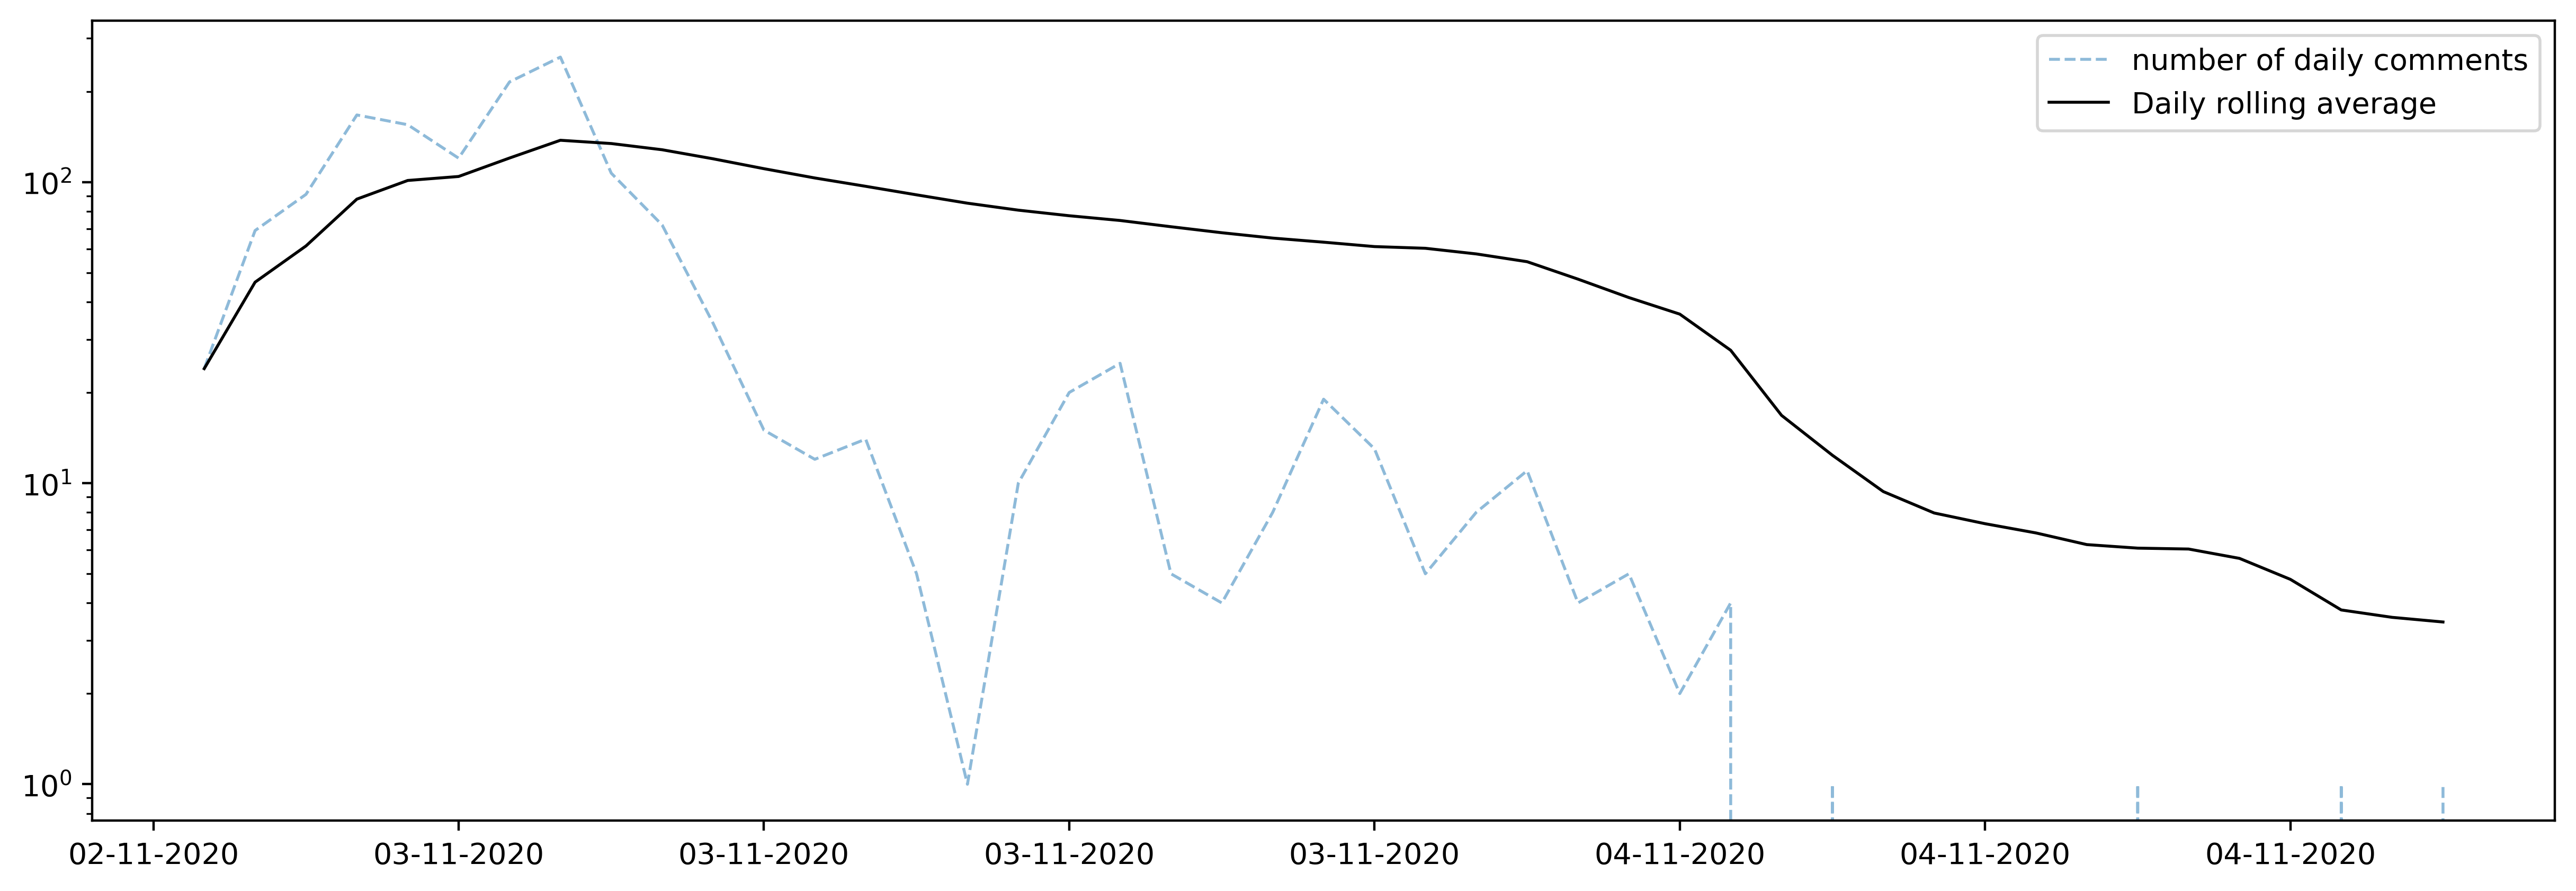

In [328]:
import matplotlib as mpl
import matplotlib.dates as mdates
#Specifying the MatPlotLib font and line width
def setup_mpl():
    mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['lines.linewidth'] = 1
setup_mpl()
myFormat = mdates.DateFormatter('%d-%m-%Y')
#Resample number of comments per day. 
daily_comments = com_data['id'].resample('H').count()

#Convert to dataframe
daily_comments_df = pd.DataFrame(
                    {
                        'Daily comments' : daily_comments.values
                    }, index = daily_comments.index)

MA_comments = daily_comments_df["Daily comments"].rolling('D').mean()
#Plot the moving average on top!

fig, ax = plt.subplots(figsize=(15,5), dpi=400)
ax.plot(daily_comments.index, daily_comments.values, ls = '--', alpha=0.5, label="number of daily comments")
ax.plot(MA_comments.index, MA_comments.values, color='k', label="Daily rolling average")
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
#ax.set_ylabel('')
ax.set_yscale('log')
ax.legend()
ax.xaxis.set_major_formatter(myFormat)

In [70]:
# Implementing the VADER sentiment analysis of the comments. 

#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
def calculate_compound_sentiment_score(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # The Compound score is a metric that calculates the sum of all the lexicon ratings 
    # which have been normalized between -1(most extreme negative) and +1 (most extreme positive).   
    
    return sentiment_dict['compound']

In [71]:
tqdm.pandas()
coms_df["compound_sentiment_score"] = coms_df["body"].progress_apply(calculate_compound_sentiment_score)

100%|██████████| 1000/1000 [00:17<00:00, 58.73it/s]


In [84]:
len(coms_df["author"].unique())

869

In [102]:
coms_df

,id,link_id,score,author,parent_id,body,parent_author,politician,children,mentions_Trump,mentions_Biden,compound_sentiment_score
dates,,,,,,,,,,,,
2020-11-03 00:48:23,gayflfy,t3_jmybs3,1,ChickenNPisza,t1_gaye3oj,They are all saving face I bet. Contradict the...,droplivefred,Trump,[],NaN,NaN,-0.7234
2020-11-02 23:25:58,gay6j16,t3_jmybs3,1,QueerlyTremendous,t1_gay46gx,In reality all trump had to do was get an hand...,LasersGirl,Trump,[],NaN,NaN,0.7050
2020-11-02 23:15:01,gay5bcm,t3_jmybs3,1,Venator850,t3_jmybs3,This really looks like Trump throwing. Last I ...,geoxol,Trump,[],True,NaN,0.1000
2020-11-02 23:04:56,gay46gx,t3_jmybs3,1,LasersGirl,t3_jmybs3,He’s beside himself because Fauci’s approval r...,geoxol,Trump,['gay6j16'],NaN,NaN,0.4767
2020-11-02 22:59:42,gay3l02,t3_jmybs3,1,qx82717,t1_gay3b6d,"Alllright, partys getting started.",J_Class_Ford,Trump,[],NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03 03:22:17,gayw6qd,t3_jmxsgq,1,OhThatNick,t3_jmxsgq,"Ah, yes, the fear that only criminals have.",JohnBasedow_,Trump,[],NaN,NaN,-0.6369
2020-11-03 03:22:16,gayw6n3,t3_jmxsgq,1,shyvananana,t1_gayjf76,Agreed. That's why we have laws on the books n...,spinfip,Trump,[],NaN,NaN,0.4043
2020-11-03 03:22:12,gayw6el,t3_jmxsgq,1,UsurpUsername,t3_jmxsgq,Seriously. For what???,JohnBasedow_,Trump,[],NaN,NaN,-0.3049


In [125]:
group = coms_df.groupby("author")

author_df_V = group.apply(lambda x: [x["politician"].unique()] )

In [127]:
list(author_df_V)

[[array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], dtype=object)],
 [array(['Trump'], d

In [122]:
author_df_V

author
-BigMan39              [[How hunter biden used his father's name to z...
-Heart_of_Dankness-    [[Sometimes when you commit a crime for a long...
-eimaj-                [[2016: Orange (Trump) is the new Black (Obama...
0O00OO0O000O           [[Good points. I haven't read the book but I'v...
1nthenet               [[Best birthday gift if he does], [0.7964], [T...
                                             ...                        
z_funny182             [[Bulletproof vest ads on a bit], [0.0], [Trump]]
zajacdan                                [[Lock him up!], [0.0], [Trump]]
zapitron               [[Cohen has already been imprisoned, found gui...
zoodiedoodie           [[I remember 2-3 years ago listening to a podc...
ztimulating            [[His adult children will most likely be keepi...
Length: 869, dtype: object

# 3 Tools, theory and analysis

# 4 Discussion

### What is still missing?

### What could be improved?

It would undoubtedly have been interesting to investigate the political content on r/politics over a longer time period, e.g. six months preceeding the election day, which would allow for the detection of longer term trends in redditor activity and sentiment. For such a scope to be feasible, bigger computational muscles than what the group members had at their disposal. 